In [1]:
import numpy as np
import pandas as pd

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from datetime import datetime

import pyproj


import descartes
%matplotlib inline
import matplotlib.pyplot as plt

import shapely
import contextily as cx

import open_cp.data
import open_cp.geometry
import open_cp.plot
import matplotlib.collections
import open_cp.kernels


In [2]:
#Intervention: 

#Consider one grid
#for each crime in that grid must calculate the prediction value for that crime in the grid point on the day of the crime 
#with each crime store that value in a dataframe 


#we need a function that takes in a date and a set of coordinates and returns the probability that predpol would return if you 
#trained it on everything prior!

In [3]:
#get the crime data from here https://data.lacity.org/Public-Safety/Crime-Data-from-2010-to-2019/63jg-8b9z
#crime = pd.read_csv('Crime_Data_from_2010_to_2019.csv')
#crime['DATE OCC'] = crime['DATE OCC'].apply(lambda x: datetime.strptime(x,  '%m/%d/%Y %H:%M:%S %p'))

crime = pd.read_csv('2018LAcrime.csv')
crime['DATE OCC'] = crime['DATE OCC'].apply(lambda x: datetime.strptime(x,  '%Y-%m-%d %H:%M:%S'))

crime = crime[crime['DATE OCC'].dt.year == 2018]
crime = crime[~((crime.LAT==0)&(crime.LON==0))]


#trim just so that we can try to implement our intervention on small subset first
#crime = crime.iloc[0:100]

#remove outliers if needed
# crime = crime[np.abs(crime.LAT-crime.LAT.mean())<=(3*crime.LAT.std())]


#df1 = crime[['LAT', 'LON']]
#df1 = df1[~((df1.LAT==0)&(df1.LON==0))]

In [4]:
import sepp.sepp_grid
import datetime

In [5]:
crime.head()

,Unnamed: 0,Unnamed: 0.1,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,0,1486140,181512537,06/08/2018 12:00:00 AM,2018-06-01 12:00:00,1,15,N Hollywood,1591,2,...,IC,Invest Cont,354.0,NaN,NaN,NaN,12100 VENTURA BL,NaN,34.1436,-118.3953
1,1,1486198,181421585,10/04/2018 12:00:00 AM,2018-10-03 12:00:00,2200,14,Pacific,1452,1,...,IC,Invest Cont,510.0,NaN,NaN,NaN,100 CATAMARAN ST,NaN,33.9781,-118.4644
2,2,1486284,181306585,02/13/2018 12:00:00 AM,2018-02-13 12:00:00,1545,13,Newton,1333,2,...,IC,Invest Cont,946.0,NaN,NaN,NaN,400 E 32ND ST,NaN,34.0188,-118.2684
3,3,1486313,181609040,05/06/2018 12:00:00 AM,2018-05-05 12:00:00,1700,16,Foothill,1651,1,...,IC,Invest Cont,510.0,NaN,NaN,NaN,9700 HADDON AV,NaN,34.2455,-118.4177
4,4,1614822,182021043,11/25/2018 12:00:00 AM,2018-11-25 12:00:00,800,20,Olympic,2026,1,...,IC,Invest Cont,510.0,NaN,NaN,NaN,BERENDO,5TH,34.0654,-118.2941


In [6]:
#isolate the timestamps
timestamps = crime['DATE OCC']

#this is the map projection for California. Will be different if we use another city. See pyproj docu
#proj = pyproj.Proj({"init":"EPSG:2229"})

In [7]:
#project
#proj = pyproj.Proj({"init":"EPSG:2229"})
#xcoords, ycoords = proj(crime['LON'].values, crime['LAT'].values)
xcoords, ycoords = crime.LON, crime.LAT

#combine time and spatial
points = open_cp.data.TimedPoints.from_coords(timestamps, xcoords, ycoords)

In [8]:
print(points.number_data_points)
print(points.time_range)

154430
(numpy.datetime64('2018-01-01T12:00:00.000'), numpy.datetime64('2018-12-31T12:00:00.000'))


In [10]:
#laurl = 'https://raw.githubusercontent.com/datadesk/geopandas-intersection-area-example/master/input/la-county-neighborhoods-v6.geojson'
#frame = gpd.read_file(laurl)
frame = gpd.read_file('/Users/annieulichney/Desktop/PredPolAnnie/County_Boundary.geojson')
geo = list(frame.geometry)[3]

#projected version
frame_proj = frame.to_crs(epsg=3857)
geo_proj = list(frame_proj.geometry)[3]

In [11]:
print(min(ycoords))
print(max(ycoords))
print(np.mean(ycoords))

print(min(xcoords))
print(max(xcoords))

33.706
34.3287
34.07686163439726
-118.6677
-118.1574


In [12]:
#project the coordinates

proj = pyproj.Proj({"init":"EPSG:3857"})
xcoords_proj, ycoords_proj = proj(crime['LON'].values, crime['LAT'].values)

/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


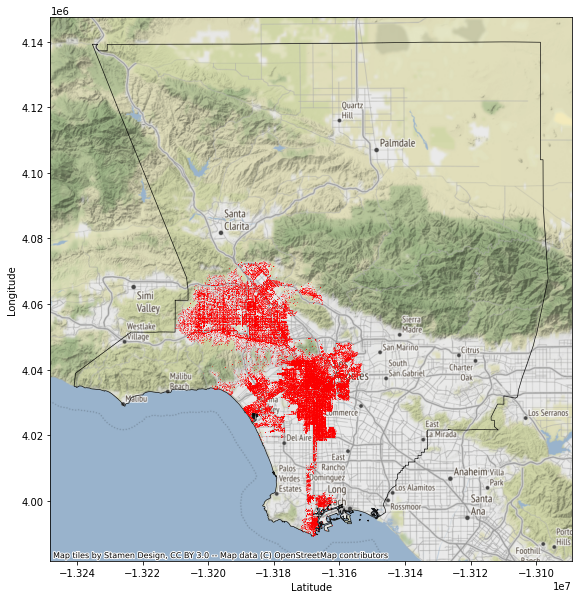

In [13]:
#ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ax = frame_proj.loc[[3],'geometry'].plot(figsize = (20,10) , 
              edgecolor='black', lw=0.7, alpha = 0.9, facecolor = "none")
cx.add_basemap(ax)
ax.scatter(xcoords_proj, ycoords_proj, marker="x", color="red", linewidth=1, s = 0.005)
#plt.title('Los Angeles County Crime 2019')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.xticks([])
#plt.yticks([])
plt.show()

In [42]:
# #fig, ax = plt.subplots(figsize=(8,8))

# #ax = frame.boundary.plot(figsize=(30, 15))
# ax = frame.loc[[3],'geometry'].plot(figsize = (20,10) , 
#               edgecolor='black', lw=0.7, alpha = 0.5, facecolor = "lightblue")
# cx.add_basemap(ax)
# ax.set_aspect(1)
# #ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
# ax.scatter(xcoords, ycoords, marker="x", color="black", linewidth=1, s = 0.05)
# plt.title('Los Angeles County Crime 2019')
# plt.xlabel('Latitude')
# plt.ylabel('Longitude')

In [14]:
#make grid on projected version

grid_proj = open_cp.data.Grid(xsize=1000, ysize=1000, xoffset=0, yoffset=0)
grid_proj = open_cp.geometry.mask_grid_by_intersection(geo_proj, grid_proj)

store_grid_proj = open_cp.plot.lines_from_grid(grid_proj)


In [15]:
off = 1000
factor = 1

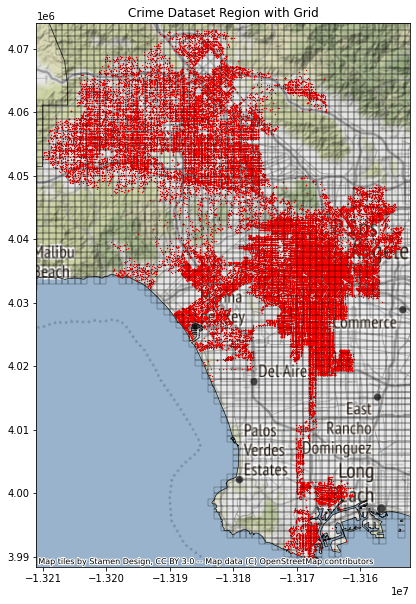

In [16]:

ax = frame_proj.loc[[3],'geometry'].plot(figsize = (20,10) , 
              edgecolor='black', lw=0.7, alpha = 0.9, facecolor = "none")
cx.add_basemap(ax)

#fig, ax = plt.subplots(figsize=(8,8))
#cx.add_basemap(ax)
ax.set_aspect(1)
lc = matplotlib.collections.LineCollection(store_grid_proj, color="black", linewidth=0.3, alpha = 0.9)
ax.add_collection(lc)
#cx.add_basemap(ax)
ax.scatter(xcoords_proj, ycoords_proj, marker="x", color="red", linewidth=0.5, s = 1)

ax.set_title("Crime Dataset Region with Grid")

#plt.xticks([])
#plt.yticks([])
#plt.xlim([factor*min(xcoords_proj), factor*max(xcoords_proj)])
#plt.ylim([factor*min(ycoords_proj), factor*max(ycoords_proj)])
plt.xlim([min(xcoords_proj) - off, max(xcoords_proj) + off])
plt.ylim([min(ycoords_proj) - off, max(ycoords_proj) + off])
plt.show()

/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 26 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


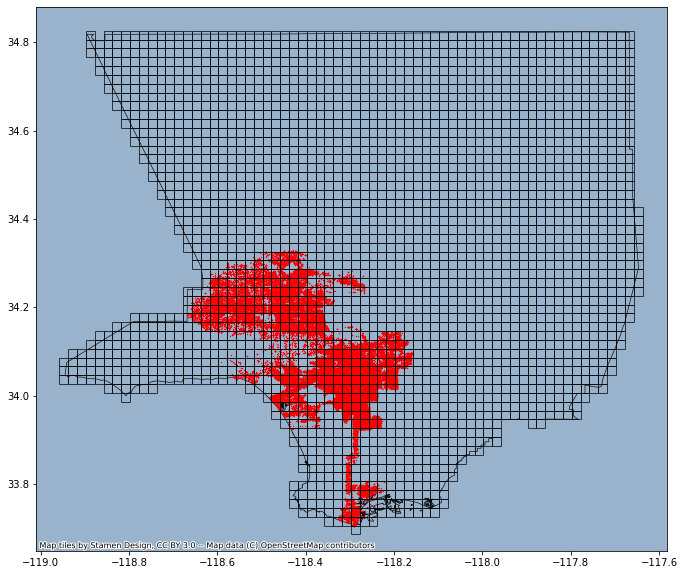

In [17]:

#not projected version

grid = open_cp.data.Grid(xsize=.02, ysize=.02, xoffset=max(xcoords), yoffset=min(ycoords))
grid = open_cp.geometry.mask_grid_by_intersection(geo, grid)
store_grid = open_cp.plot.lines_from_grid(grid)

ax = frame.loc[[3],'geometry'].plot(figsize = (20,10) , 
              edgecolor='black', lw=0.7, alpha = 0.9, facecolor = "none")
cx.add_basemap(ax)

ax.set_aspect(1)
lc = matplotlib.collections.LineCollection(store_grid, color="black", linewidth=0.7)
ax.add_collection(lc)
ax.scatter(xcoords, ycoords, marker="x", color="red", linewidth=0.5, s = 1)

In [18]:
points_proj = open_cp.data.TimedPoints.from_coords(timestamps, xcoords_proj, ycoords_proj)

In [19]:
#train the data
trainer = sepp.sepp_grid.ExpDecayTrainer(grid_proj)
trainer.data = points_proj


In [20]:
#model = trainer.train(datetime.datetime(2019,12,1))

model = trainer.train()

/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [50]:
model

ExpDecayModel(T=362.0, theta=5.293340420175334e-16, omega=0.03925254312081743, mu size=(151, 145)

In [21]:
max_range = max((max(xcoords_proj) - min(xcoords_proj)), (max(ycoords_proj) - min(ycoords_proj)))

In [22]:
(max(ycoords_proj) - min(ycoords_proj))

83631.26813502004

In [23]:
off = 2000

In [24]:
#how do we go from xcoords to the grid index? 

In [25]:
pred.index[pred.intensity_matrix != 0]

NameError: name 'pred' is not defined

In [71]:
ycoords_proj[72]

4033368.3096225876

In [26]:
x_index = 72
y_index = 72
grid_x, grid_y = grid_proj.grid_coord(xcoords_proj[x_index], ycoords_proj[y_index])

pred.intensity_matrix[grid_y][grid_x]

NameError: name 'pred' is not defined

/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


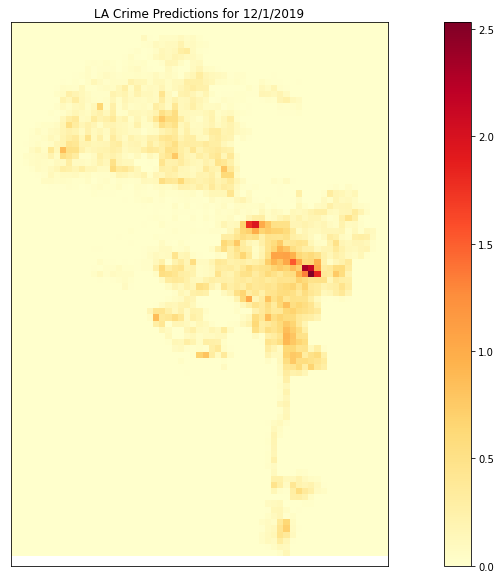

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
ax.add_patch(descartes.PolygonPatch(geo_proj, fc="none"))
ax.set_aspect(1)

pred = trainer.prediction_from_background(model)
mappable = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="YlOrRd", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("LA Crime Predictions for 12/1/2019")
None
plt.xlim([min(xcoords_proj) - off, max(xcoords_proj) + off])
plt.ylim([min(ycoords_proj) - off, max(ycoords_proj) + off])
plt.xticks([])
plt.yticks([])
plt.show()

In [150]:
import sepp.kernels
import sepp.sepp_full
import numpy as np
import scipy.stats
from datetime import datetime

In [151]:
tk_time_prov = sepp.kernels.FixedBandwidthKernelProvider(1)
tk_space_prov = sepp.kernels.FixedBandwidthKernelProvider(20, cutoff=750)
back_ker_prov = sepp.kernels.FixedBandwidthKernelProvider(100)
opt_fac = sepp.sepp_full.Optimiser1Factory(back_ker_prov, tk_time_prov, tk_space_prov)
trainer = sepp.sepp_full.Trainer1(opt_fac)
trainer.data = points_proj
model = trainer.train(datetime(2019,12,1), iterations=5)
model

KeyboardInterrupt: 

In [ ]:
def compute_plot_kde(ker, size):
    x = np.linspace(-size, size, 151)
    y = x
    xcs, ycs = np.meshgrid(x, y)
    z = ker([xcs.flatten(), ycs.flatten()])
    z = z.reshape(xcs.shape)
    return x, y, z

def plot_kde(ax, ker, size, postprocess=None):
    x, y, z = compute_plot_kde(ker, size)
    if postprocess is not None:
        z = postprocess(z)
    return ax.pcolormesh(x,y,z, cmap="Greys", rasterized=True)

def backup_limits(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    return xmin, xmax, ymin, ymax

def set_limits(ax, xmin, xmax, ymin, ymax):
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    
def plot(model, space_size=35, time_size=100, space_floor=None):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    ax = axes[0]
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    bpred = open_cp.predictors.grid_prediction_from_kernel(model.background_kernel, grid.region(), grid.xsize)
    #bpred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
    m = ax.pcolor(*bpred.mesh_data(), bpred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)

    ax = axes[1]
    x = np.linspace(0, time_size, 200)
    y = model.theta * model.trigger_time_kernel(x)
    ax.plot(x, y, color="black")
    ax.set(xlabel="Days", ylabel="Trigger risk")
    y = np.max(y)
    for t in range(0, time_size+1):
        ax.plot([t,t],[0,y], color="grey", linewidth=0.5, linestyle="--", zorder=-10)

    pp = None
    if space_floor is not None:
        pp = lambda z : np.log(space_floor + z)
    m = plot_kde(axes[2], model.trigger_space_kernel, space_size, pp)
    plt.colorbar(m, ax=axes[2])
        
    fig.tight_layout()
    return fig

def plot_scatter_triggers(backgrounds, trigger_deltas):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    def add_kde(ax, pts):
        xmin, xmax, ymin, ymax = backup_limits(ax)
        x = np.linspace(xmin, xmax, 151)
        y = np.linspace(ymin, ymax, 151)
        xcs, ycs = np.meshgrid(x, y)
        ker = scipy.stats.kde.gaussian_kde(pts)
        z = ker([xcs.flatten(), ycs.flatten()])
        z = z.reshape(xcs.shape)
        z = np.log(np.exp(-15)+z)
        m = ax.pcolorfast(x,y,z, cmap="Greys", rasterized=True, alpha=0.7, zorder=-10)

    ax = axes[0]
    pts = trigger_deltas[1:]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set_title("Space trigger points")

    ax = axes[1]
    pts = trigger_deltas[[0,1]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="x coord")#, xlim=[0,200])

    ax = axes[2]
    pts = trigger_deltas[[0,2]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="y coord")

    fig.tight_layout()
    return fig

def scatter_triggers(trainer, model, predict_time):
    backgrounds, trigger_deltas = trainer.sample_to_points(model, predict_time)
    return plot_scatter_triggers(backgrounds, trigger_deltas), backgrounds, trigger_deltas

In [ ]:
fig = plot(model, space_size=750, time_size=20, space_floor=np.exp(-20))

In [ ]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))